In [42]:
from astropy.nddata.utils import Cutout2D
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

OUT_PATH = "out"#"/run/media/toyonagar/Lexar/out/out"
MERGED_PATH = "merged_"#"/run/media/toyonagar/Lexar/merged/merged_"
def normalize( all_cutouts, all_lenses): #only for 1 color channel
    
    for lens_number in range(hm_lenses):
        tmp_lens = all_lenses[lens_number][0].reshape(-1,)
        tmp_lens = minmax_scale(tmp_lens, feature_range = (all_cutouts[lens_number][0].min(), all_cutouts[lens_number][0].max()*0.75))
        all_lenses[lens_number][0] = tmp_lens.reshape(all_lenses.shape[2],all_lenses.shape[2])
    '''
    minmax_cutout = make_scaler2(all_cutouts)
    minmax_lens = make_scaler2(all_lenses)
    all_cutouts = scale_data2(all_cutouts, minmax_cutout)
    all_lenses = scale_data2(all_lenses, minmax_lens)
    '''
    return all_cutouts, all_lenses
    

def load_images(sample_num):
    
    try:
        lens = fits.open("/home/toyonagar/anaconda3/HST_Lens/lens_image_"+str(sample_num)+".fits")[0].data #PATH will  run dir
    except:
        print "lens messed up"
    try:
        cutout = fits.open("out"+str(sample_num)+".fits")[0].data 
    except:
        print "out messed up"
    try:
        cutout = cutout.reshape(1,cutout.shape[0],cutout.shape[1])
        lens = lens.reshape(1,lens.shape[0],lens.shape[1])
    except: 
        print "reshape" 
    return cutout, lens
    

def save_images(hm_lenses, merged):
    
    for image in range(len(merged)):
        fits.writeto(MERGED_PATH + str(image)+'.fits', merged[image], overwrite =True) #PATH
    

def sum_images(all_cutouts, all_lenses): #only sums in 2D, no color channel
    summed = []
    for image_number in range(hm_lenses):    
        summed.append(np.add(all_cutouts[image_number][0], all_lenses[image_number][0])) 
    return summed

hm_lenses = input("How many lenses do you want to merge with associated cutouts? ")

all_cutouts = np.zeros((hm_lenses,1,100,100))
all_lenses = np.zeros((hm_lenses,1,100,100))

bad_images = [] #keep track of and remove bad images later

for i in range(hm_lenses):
    try:
        all_cutouts[i], all_lenses[i] = load_images(i)
    except:
        bad_images.append(i)
        print("couldnt find image: " +str(i))
        
hm_lenses -=len(bad_images)        
all_cutouts = np.delete(all_cutouts,bad_images, axis=0)
all_lenses = np.delete(all_lenses,bad_images, axis=0)
    
print("images loaded") 

all_cutouts, all_lenses = normalize(all_cutouts, all_lenses)
print("images normalized")   
    
merged = sum_images(all_cutouts, all_lenses)  
tmp_image =  merged[image]
print("images merged") 

bad_images = []
for image in range(len(merged)):
    try:
        tmp_image = merged[image].reshape(-1,)
        tmp_image = minmax_scale(tmp_image, feature_range = (0,1))
        merged[image] = tmp_image.reshape(merged[image].shape[0],merged[image].shape[1])
    except:
        bad_images.append(image)
        print ("image contains NaN")
hm_lenses -=len(bad_images)        
merged = np.delete(merged,bad_images, axis=0)

    
print ("images re-normalized")

save_images(hm_lenses, merged)

print(" merged images saved ")

How many lenses do you want to merge with associated cutouts? 99
out messed up
reshape
couldnt find image: 2
out messed up
reshape
couldnt find image: 14
out messed up
reshape
couldnt find image: 15
out messed up
reshape
couldnt find image: 18
out messed up
reshape
couldnt find image: 19
out messed up
reshape
couldnt find image: 20
out messed up
reshape
couldnt find image: 22
out messed up
reshape
couldnt find image: 23
out messed up
reshape
couldnt find image: 25
out messed up
reshape
couldnt find image: 29
out messed up
reshape
couldnt find image: 30
out messed up
reshape
couldnt find image: 31
out messed up
reshape
couldnt find image: 35
out messed up
reshape
couldnt find image: 37
out messed up
reshape
couldnt find image: 38
out messed up
reshape
couldnt find image: 39
out messed up
reshape
couldnt find image: 42
out messed up
reshape
couldnt find image: 46
out messed up
reshape
couldnt find image: 49
out messed up
reshape
couldnt find image: 51
out messed up
reshape
couldnt find i

62

In [54]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np 

def make_scaler2(x_tmp ):
    #this will get a min and max for each channel
    
    linx= []
    
    x_tmp=x_tmp.reshape(x_tmp.shape[0],x_tmp.shape[1],x_tmp.shape[3]**2)#color in 2nd channel

    for color in range(x_tmp.shape[1]):
        linx.append(np.zeros(x_tmp.shape[0]*x_tmp.shape[2]) ) #x.shape[2] =101*101
        for image in range(x_tmp.shape[0]):
            linx[color][image*x_tmp.shape[2] : (image+1)*x_tmp.shape[2]] = x_tmp[image][color]

    
    minmax_dict = {"max": [],"min": [] } 
    for color in range(x_tmp.shape[1]):
        minmax_dict['max'].append(linx[color].reshape(-1).max())
        minmax_dict['min'].append(linx[color].reshape(-1).min())
        

            
    #print(linx[0]==linx[1])#linx[1].reshape(-1, 1).shape)
    return minmax_dict

def scale_data2(x_tmp, minmax_dict):
    linx= []
    
    #reshape
    x_tmp=x_tmp.reshape(x_tmp.shape[0],x_tmp.shape[1],x_tmp.shape[3]**2)
    
    #get it in a line
    for color in range(x_tmp.shape[1]):
        linx.append(np.zeros(x_tmp.shape[0]*x_tmp.shape[2]) ) #x.shape[2] =101*101
        for image in range(x_tmp.shape[0]):
            linx[color][image*x_tmp.shape[2] : (image+1)*x_tmp.shape[2]] = x_tmp[image][color]
        print(linx[color].max())
    #transform/scale
    transx = []
    for color in range(x_tmp.shape[1]): 
        X_std = (linx[color] - minmax_dict["min"][color]) / (minmax_dict["max"][color] - minmax_dict["min"][color])
        #X_scaled = X_std * (minmax_dict["max"][color] - minmax_dict["min"][color]) + minmax_dict["min"][color]
        transx.append(X_std)
 
    #store in original 4d array
    for image in range(x_tmp.shape[0]):
        for color in range(x_tmp.shape[1]):
            x_tmp[image][color] = transx[color][image*x_tmp.shape[2] : (image+1)*x_tmp.shape[2]].reshape(1,-1) 
    #reshape back to original dimensions
    x_tmp = x_tmp.reshape(x_tmp.shape[0],1,100,100)
    return x_tmp

In [548]:
'''          TRY SIMULATING AND LOADING pixel.fits AGAIN IT WILL BE 200,200


This script receives .fits images from lenstool and downloaded adjusted cutouts. It will then, for each cutout,
normalize and add the two components together.

'''
from astropy.nddata.utils import Cutout2D
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

def normalize( all_cutouts, all_lenses): #only for 1 color channel
    
    for lens_number in range(hm_lenses):
        tmp_lens = all_lenses[lens_number][0].reshape(-1,)
        tmp_lens = minmax_scale(tmp_lens, feature_range = (all_cutouts[lens_number][0].min(), all_cutouts[lens_number][0].max()*0.75))
        all_lenses[lens_number][0] = tmp_lens.reshape(all_lenses.shape[2],all_lenses.shape[2])
    '''
    minmax_cutout = make_scaler2(all_cutouts)
    minmax_lens = make_scaler2(all_lenses)
    all_cutouts = scale_data2(all_cutouts, minmax_cutout)
    all_lenses = scale_data2(all_lenses, minmax_lens)
    '''
    return all_cutouts, all_lenses
    

def load_images(sample_num):
    cutout = fits.open("out"+str(sample_num)+".fits")[0].data
    lens = fits.open("lens_image_"+str(sample_num)+".fits")[0].data
    cutout = cutout.reshape(1,cutout.shape[0],cutout.shape[1])
    lens = lens.reshape(1,lens.shape[0],lens.shape[1])
    
    return cutout, lens
    

def save_images(hm_lenses, merged):
    for image in range(len(merged)):
        fits.writeto('merged_'+str(image)+'.fits', merged[image], overwrite =True)
    pass

def sum_images(all_cutouts, all_lenses): #only sums in 2D, no color channel
    summed = []
    for image_number in range(hm_lenses):    
        summed.append(np.add(all_cutouts[image_number][0], all_lenses[image_number][0])) 
    return summed

hm_lenses = input("How many lenses do you want to merge with associated cutouts? ")

all_cutouts = np.zeros((hm_lenses,1,100,100))
all_lenses = np.zeros((hm_lenses,1,100,100))

bad_images = [] #keep track of and remove bad images later

for i in range(hm_lenses):
    try:
        all_cutouts[i], all_lenses[i] = load_images(i)
    except:
        bad_images.append(i)
        print("couldnt find image: " +str(i))
        
hm_lenses -=len(bad_images)        
all_cutouts = np.delete(all_cutouts,bad_images, axis=0)
all_lenses = np.delete(all_lenses,bad_images, axis=0)
    
print("images loaded")   

all_cutouts, all_lenses = normalize(all_cutouts, all_lenses)
print("images normalized")   
    
merged = sum_images(all_cutouts, all_lenses)  
    
print("images merged") 
for image in range(len(merged)):
    tmp_image = merged[image].reshape(-1,)
    tmp_image = minmax_scale(tmp_image, feature_range = (0,1))
    merged[image] = tmp_image.reshape(merged[image].shape[0],merged[image].shape[1])
print ("images re-normalized")

save_images(hm_lenses, merged)

print(" merged images saved ")

How many lenses do you want to merge with associated cutouts? 9
couldnt find image: 2
images loaded
images normalized
images merged
images re-normalized
 merged images saved 


In [111]:
all_cutouts.shape, all_lenses.shape,  bad_images


((9, 1, 100, 100), (9, 1, 100, 100), [2])

In [164]:
np.add(all_cutouts[1][0], all_lenses[1][0]).shape , merged[6].max()

((100, 100), 1.0)

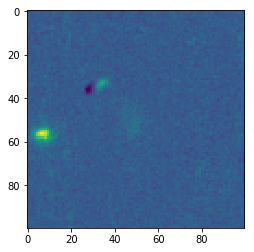

In [587]:
plt.imshow(merged[2])

In [ ]:
lens = fits.open("pixel0.fits")[0].data
plt.subplot(221)
plt.imshow(lens) 


In [259]:
0.05*100

5.0

In [ ]:

padded = np.zeros((200,200))
for i in range(175):
    padded[i+12] = lens[i] #offset by 12 to get lens right in the middle
print(padded.shape)
plt.imshow(padded) 


In [ ]:
from sklearn.preprocessing import minmax_scale

#normalize min max to that of real image
lens_scaled=padded.reshape(-1,)
lens_scaled = minmax_scale(lens_scaled ,feature_range=(cutout_list[0].data.max()*0.0, cutout_list[0].data.max()*0.5))
lens_scaled = lens_scaled.reshape(padded.shape[0],padded.shape[1])
plt.imshow(lens_scaled) 

In [ ]:
lens_scaled.shape

In [ ]:

image =0
summed = np.add(cutout_list[image].data,lens_scaled)
plt.imshow(summed)


resolved_summed.max()

In [ ]:
resolved_summed.max()

In [ ]:
low_noise

In [19]:
lens = fits.open("pixel0.fits")[0].data

In [20]:
lens.shape

(175, 200)

In [75]:
import random
(float(random.randint(101,151))/100.)

1.45

168

In [15]:
from astropy.nddata.utils import Cutout2D
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

cutout = fits.open("cutout_"+str(0)+".fits")[1].data
lens = fits.open("lens_image_"+str(0)+".fits")[0].data

In [16]:
cutout

array([[-0.00044629,  0.00446702, -0.00241025, ...,  0.00828977,
         0.00973403,  0.00850428],
       [ 0.01214066,  0.00505024, -0.0004322 , ...,  0.00418377,
         0.00666567,  0.00831932],
       [ 0.00530785,  0.00613436,  0.00111257, ..., -0.00171342,
         0.00041152,  0.01038589],
       ..., 
       [-0.0020945 , -0.00673738,  0.00529338, ..., -0.00110314,
        -0.00173045, -0.00149392],
       [ 0.00016046, -0.00484465, -0.00014531, ...,  0.00103249,
         0.00914244,  0.00238283],
       [ 0.00136914,  0.00307508,  0.0007001 , ...,  0.00453573,
        -0.00268185, -0.00149576]], dtype=float32)

In [573]:
import pandas as pd
dataframe = pd.read_csv("with_zphot.tsv",delimiter=";")

In [574]:
len(dataframe)

18659

In [575]:
dataframe

,Seq,zsp,Class,r_Class,zphot,zbest,Zlim,S/G,pos,st,Gal,RAJ2000,DEJ2000
0,,,,,,,mag,,,,,deg,deg
1,-----,------,---------,--------,---------,------,------,----,-,-,-,----------,----------
2,1,,UNKNOWN,UNKNOWN,,,,0.97,0,0,0,053.147888,-27.943951
3,2,0.776,GALAXY,VVDS,,,28.019,0.02,0,0,0,053.086289,-27.945091
4,3,1.370,EMISSION,GOODS,,,,0.03,0,0,0,053.120064,-27.945618
5,4,,UNKNOWN,UNKNOWN,,,,0.98,0,0,0,053.135841,-27.945583
6,5,0.804,GALAXY,VVDS,,,,0.01,0,0,0,053.123756,-27.945667
7,6,,UNKNOWN,UNKNOWN,,,,0.95,0,0,0,053.222923,-27.945658
8,7,,UNKNOWN,UNKNOWN,,,,0.17,0,0,0,053.084827,-27.945704
9,8,,UNKNOWN,UNKNOWN,,,,0.24,0,0,0,053.142502,-27.945722
